# Dogs Vs Cats Classification using Tensorflow and Keras with VGG16 Transfer Learning + Fine Tuning

No caching done here as we want to do data augmentation on training data using the best fc layer we have tried earlier.
Subequently we want to fine tune the by training earlier layers

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import applications, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input

## Define constants

In [35]:
# dimensions of our images
img_width, img_height = 224,224 #224,224 for VGG16 by default

PATH = 'data/dogscats_small/'
train_data_dir = f'{PATH}train/'
validation_data_dir = f'{PATH}validation/'
test_data_dir = f'{PATH}test/'
epochs = 10
batch_size = 16

In [36]:
# value stored in /users/<user>/keras/.keras.json file
# "channels_last" for tensorflow

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Helper functions

In [37]:
# ensure the child directories are non-empty and contain jpg files
def rand_img_from_child_dirs(dir_path):
    
    dirs =  [directory for directory in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,directory)) 
             and not directory.startswith('.')]
    random_dir = np.random.choice(dirs)
    random_dir_path = os.path.join(dir_path,random_dir)
    files =  [file for file in os.listdir(random_dir_path) if file.endswith('.jpg')]
    random_img = np.random.choice(files)

    return os.path.join(random_dir_path,random_img)

In [38]:
def plot_training_history(log):
    acc = log.history['acc']
    val_acc = log.history['val_acc']
    loss = log.history['loss']
    val_loss = log.history['val_loss']

    epoch_range = range(len(acc))

    plt.plot(epoch_range, acc, 'b', label='Training acc')
    plt.plot(epoch_range, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epoch_range, loss, 'b', label='Training loss')
    plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [39]:
def print_layer_trainable(model):
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

## Transfer Learning

### Prepare Training Data

In [40]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [41]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Build pre-trained model

For future reference:

To detach the conv model from the fc layers from a full VGG model

`model = applications.VGG16(include_top=True, weights='imagenet', input_shape=input_shape)`

`transfer_layer = base_model.get_layer('block5_pool')`

`transfer_layer.output`

`conv_model = Model(inputs=model.input,outputs=transfer_layer.output)`

Alternatively, just download without the last layers by setting include_top = False and do below

In [42]:
conv_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#conv_model.summary()

In [43]:
build_with_sequential = False # else it would be functional
fc_type = 3

if build_with_sequential:
    new_model = Sequential()
    new_model.add(conv_model)

    if fc_type == 1:
        new_model.add(Flatten())
        new_model.add(Dense(256, activation='relu')) # Keras blog version
        new_model.add(Dropout(0.5))
    elif fc_type == 2:
        new_model.add(Flatten())
        new_model.add(Dense(1024, activation='relu')) # Magnus Pedersen Version
        new_model.add(Dropout(0.5))
    else:
        # fastai jeremy's version
        new_model.add(GlobalAveragePooling2D())
        new_model.add(Dense(1024, activation='relu'))

    new_model.add(Dense(1, activation='sigmoid'))
    
else:
    x = conv_model.output

    if fc_type == 1:
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
    elif fc_type == 2:
        x = Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)
    else:
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid')(x)
    new_model = Model(inputs=conv_model.input, outputs=predictions)

In [44]:
# Building with Sequential will merge conv_model as one single layer 
# new_model will be of Sequential class

# Building with Functional will retain conv_model layer structures
# new_model will be of Model class

print(type(new_model))
new_model.summary()

<class 'tensorflow.python.keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPool

In [45]:
#print_layer_trainable(new_model)

In [46]:
# Freeze VGG16 conv layers
if build_with_sequential:
    conv_model.trainable = False
else:
    for layer in conv_model.layers: 
        layer.trainable = False

In [47]:
print_layer_trainable(new_model)

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
True:	global_average_pooling2d_1
True:	dense_2
True:	dense_3


In [48]:
# compile must be called after the trainable are set
new_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
%%time
training_log = new_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    workers=4,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/10
125/125 [==============================] - 29s 231ms/step - loss: 0.5429 - acc: 0.9335 - val_loss: 0.2358 - val_acc: 0.9675
Epoch 2/10
125/125 [==============================] - 27s 218ms/step - loss: 0.2988 - acc: 0.9655 - val_loss: 0.2168 - val_acc: 0.9725
Epoch 3/10
125/125 [==============================] - 27s 219ms/step - loss: 0.2122 - acc: 0.9705 - val_loss: 0.1436 - val_acc: 0.9838
Epoch 4/10
125/125 [==============================] - 27s 218ms/step - loss: 0.1431 - acc: 0.9790 - val_loss: 0.2696 - val_acc: 0.9675
Epoch 5/10
125/125 [==============================] - 27s 217ms/step - loss: 0.1220 - acc: 0.9800 - val_loss: 0.1415 - val_acc: 0.9812
Epoch 6/10
125/125 [==============================] - 27s 217ms/step - loss: 0.0846 - acc: 0.9850 - val_loss: 0.1364 - val_acc: 0.9788
Epoch 7/10
125/125 [==============================] - 27s 218ms/step - loss: 0.1191 - acc: 0.9820 - val_loss: 0.1860 - val_acc: 0.9775
Epoch 8/10
125/125 [==============================] - 2

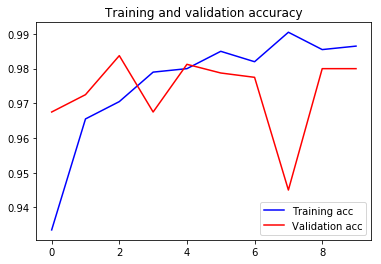

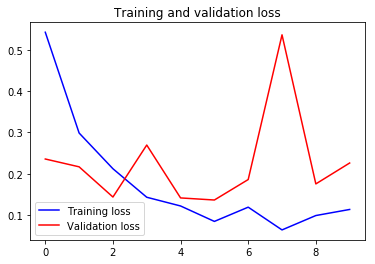

In [50]:
plot_training_history(training_log)

### Save model

#### Save as full model

In [51]:
os.makedirs(f'{PATH}models/', exist_ok=True)

In [52]:
new_model.save(f'{PATH}/models/vgg16_bottleneck_fc_model.h5')

#### Save as architecture definition (json) + weights value

In [53]:
model_json = new_model.to_json()

with open(f'{PATH}/models/vgg16_bottleneck_fc_arch.json', 'w') as json_file:
    json_file.write(model_json)
    
new_model.save_weights(f'{PATH}/models/vgg16_bottleneck_fc_weights.h5')

### Load model to predict test data

In [54]:
# both options should return the same model but we may want to 
# change the weights using those obtained from training
load_from_model_file = True

if load_from_model_file:
    test_model = load_model(f'{PATH}/models/vgg16_bottleneck_fc_model.h5')
else:
    json_file = open(f'{PATH}/models/vgg16_bottleneck_fc_arch.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    test_model = model_from_json(loaded_model_json)

    test_model.load_weights(f'{PATH}/models/vgg16_bottleneck_fc_weights.h5')

In [55]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [56]:
print_layer_trainable(test_model)

True:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
True:	global_average_pooling2d_1
True:	dense_2
True:	dense_3


### Predict on single image

data/dogscats_small/validation/dogs/dog.1011.jpg


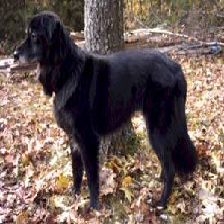

In [57]:
rand_img_path = rand_img_from_child_dirs(validation_data_dir)
rand_img = image.load_img(rand_img_path, target_size=(img_width, img_height))    
rand_dog_cat = 'dog' if 'validation/dogs' in rand_img_path else 'cat'

print(rand_img_path)
rand_img

In [58]:
x_test = image.img_to_array(rand_img)
x_test = preprocess_input(x_test)
x_test = np.expand_dims(x_test, axis=0) # increase dimension so that can be fed into model

In [59]:
prob = np.asscalar(np.squeeze(test_model.predict(x_test)))
prob

1.0

In [60]:
res = 'dog' if prob>=0.5 else 'cat'
pct = round(prob*100,2)
if res is 'cat':
    pct = 100 - pct 

print('The model is ' + str(pct) + '% sure this is a ' + res)

The model is 100.0% sure this is a dog


### Predict on batch of test images

Unlike validation data, these are never seen or tested before

In [61]:
def model_predict(data_dir, model):
    probs = []
    for fn in os.listdir(data_dir):
        img = load_img(data_dir+fn, target_size=(img_width,img_height))
        x = img_to_array(img)
        x = preprocess_input(x)
        x = np.expand_dims(x, axis=0)
        
        prob = np.asscalar(np.squeeze(model.predict(x)))
        probs.append(prob)

    return np.array(probs)

In [62]:
dog_test_dir = f"{test_data_dir}dogs/"
cat_test_dir = f"{test_data_dir}cats/"

In [63]:
pred_dogs = model_predict(dog_test_dir, test_model)

In [64]:
pred_cats = model_predict(cat_test_dir, test_model)

In [65]:
cat_acc = len(pred_cats[pred_cats<0.5])/len(pred_cats) * 100
dog_acc = len(pred_dogs[pred_dogs>=0.5])/len(pred_dogs) * 100
overall_acc = (cat_acc+dog_acc)/2.0

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')
print(f'Overall Accuracy: {overall_acc:.2f}%')

Cat Prediction Accuracy: 96.30%
Dog Prediction Accuracy: 98.70%
Overall Accuracy: 97.50%


10 Epochs Results

Baseline:
- Cat Prediction Accuracy: 77.80%
- Dog Prediction Accuracy: 77.30%
- Overall Accuract: 77.55%

Sequential_1
- Cat Prediction Accuracy: 97.60%
- Dog Prediction Accuracy: 89.80%
- Overall Accuracy: 93.70%

Sequential_2
- Cat Prediction Accuracy: 98.30%
- Dog Prediction Accuracy: 91.00%
- Overall Accuracy: 94.65%

Sequential_3
- Cat Prediction Accuracy: 97.50%
- Dog Prediction Accuracy: 94.60%
- Overall Accuracy: 96.05%

224x224 img
- Cat Prediction Accuracy: 97.20%
- Dog Prediction Accuracy: 98.40%
- Overall Accuracy: 97.80%

Functional_1
- Cat Prediction Accuracy: 97.20%
- Dog Prediction Accuracy: 94.20%
- Overall Accuract: 95.70%

Functional_2
- Cat Prediction Accuracy: 98.10%
- Dog Prediction Accuracy: 89.80%
- Overall Accuracy: 93.95%

224x224 img
- Cat Prediction Accuracy: 99.10%
- Dog Prediction Accuracy: 91.10%
- Overall Accuracy: 95.10%

Functional_3
- Cat Prediction Accuracy: 98.10%
- Dog Prediction Accuracy: 92.30%
- Overall Accuracy: 95.20%

224x224 img
- Cat Prediction Accuracy: 96.30%
- Dog Prediction Accuracy: 98.70%
- Overall Accuracy: 97.50%


## Fine-tuning

In [86]:
finetune_model = load_model(f'{PATH}/models/vgg16_bottleneck_fc_model.h5')
# finetune_model.summary()

In [87]:
print_layer_trainable(finetune_model)

True:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
True:	global_average_pooling2d_1
True:	dense_2
True:	dense_3


In [88]:
for layer in finetune_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block1' in layer.name or 
                 'block2' in layer.name or 
                 'block3' in layer.name or 
                 'input_' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = not trainable

In [89]:
print_layer_trainable(finetune_model)

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	global_average_pooling2d_1
True:	dense_2
True:	dense_3


In [90]:
#optimizer_fine = optimizers.Adam(lr=1e-7)
optimizer_fine = optimizers.RMSprop(lr=1e-6)
#optimizer_fine = optimizers.SGD(lr=1e-6, momentum=0.9)

In [91]:
# compile must be called after the trainable are set
finetune_model.compile(optimizer=optimizer_fine, loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
%%time
finetune_training_log = finetune_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    workers=4,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/10
125/125 [==============================] - 40s 321ms/step - loss: 0.0370 - acc: 0.9935 - val_loss: 0.2156 - val_acc: 0.9788
Epoch 2/10
125/125 [==============================] - 37s 298ms/step - loss: 0.0295 - acc: 0.9970 - val_loss: 0.2080 - val_acc: 0.9825
Epoch 3/10
125/125 [==============================] - 37s 298ms/step - loss: 0.0287 - acc: 0.9945 - val_loss: 0.1968 - val_acc: 0.9825
Epoch 4/10
125/125 [==============================] - 37s 296ms/step - loss: 0.0155 - acc: 0.9965 - val_loss: 0.1959 - val_acc: 0.9838
Epoch 5/10
125/125 [==============================] - 37s 297ms/step - loss: 0.0082 - acc: 0.9985 - val_loss: 0.1963 - val_acc: 0.9838
Epoch 6/10
125/125 [==============================] - 37s 298ms/step - loss: 0.0077 - acc: 0.9980 - val_loss: 0.1962 - val_acc: 0.9775
Epoch 7/10
125/125 [==============================] - 37s 297ms/step - loss: 0.0122 - acc: 0.9975 - val_loss: 0.1991 - val_acc: 0.9838
Epoch 8/10
125/125 [==============================] - 3

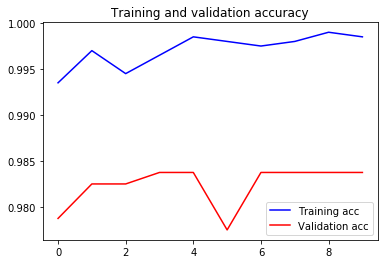

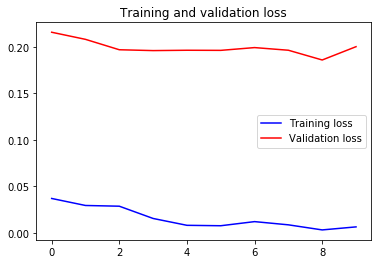

In [93]:
plot_training_history(finetune_training_log)

In [94]:
pred_dogs = model_predict(dog_test_dir, finetune_model)
pred_cats = model_predict(cat_test_dir, finetune_model)

In [95]:
cat_acc = len(pred_cats[pred_cats<0.5])/len(pred_cats) * 100
dog_acc = len(pred_dogs[pred_dogs>=0.5])/len(pred_dogs) * 100
overall_acc = (cat_acc+dog_acc)/2.0

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')
print(f'Overall Accuracy: {overall_acc:.2f}%')

Cat Prediction Accuracy: 97.20%
Dog Prediction Accuracy: 98.70%
Overall Accuracy: 97.95%


Before Tuning:

150_Functional_2
- Cat Prediction Accuracy: 92.40%
- Dog Prediction Accuracy: 96.80%
- Overall Accuracy: 94.60%

224_Functional_3
- Cat Prediction Accuracy: 96.30%
- Dog Prediction Accuracy: 98.70%
- Overall Accuracy: 97.50%

After Tuning (Freezing Block 1,2, 3):
    
With Adam(lr=1e-7)
- Cat Prediction Accuracy: 96.50%
- Dog Prediction Accuracy: 94.80%
- Overall Accuracy: 95.65%

With RMSprop(lr=1e-6)
- Cat Prediction Accuracy: 97.90%
- Dog Prediction Accuracy: 92.30%
- Overall Accuracy: 95.10%

224_img
- Cat Prediction Accuracy: 97.20%
- Dog Prediction Accuracy: 98.70%
- Overall Accuracy: 97.95%

With RMSprop(lr=1e-7)
- Cat Prediction Accuracy: 94.50%
- Dog Prediction Accuracy: 96.20%
- Overall Accuracy: 95.35%

222_img
- Cat Prediction Accuracy: 97.00%
- Dog Prediction Accuracy: 98.60%
- Overall Accuracy: 97.80%

With SGD(lr=1e-6, momentum=0.9)
- Cat Prediction Accuracy: 98.30%
- Dog Prediction Accuracy: 90.20%
- Overall Accuracy: 94.25%